<a href="https://colab.research.google.com/github/eunhye1kim/interactive-data-analysis/blob/main/dataframe_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install langgraph
!pip install langchain_openai
!pip install langchain_experimental
!pip install happybase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.3/782.3 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for happybase: filename=happybase-1.2.0-py2.py3-none-any.whl size=26603 sha256=d668efb297a295cce0fa152765bc6c8b359a2250ed7af74bf3c22d172afbf40e
  Stored in directory: /root/.cache/pip/wheels/95/d9/40/aef1e677ca6b53d419ead4f533d2a44198a1ce0b7b36b2437f
  Created wheel for thriftpy2: filename=thriftpy2-0.5.2-cp310-cp310-linux_x86_64.whl size=1749962 sha256=82005ed7f26441e247cce9ecdfb41e715ab1f0dc5aa446969942899eca11c77e
  Stored in directory: /root/.cache/pip/wheels/90/28/5f/279788e86e2eaccb3edc73bde9c815a9527602739a56344ff7
Successfully built happybase thriftpy2


In [7]:
import os
os.environ["OPENAI_API_KEY"] = "your-api-key"

Thought: We need to display the basic statistics of the dataframe and create appropriate graphs.
Action: Use describe() to display basic statistics and create a histogram for each column.
Action Input: 
```python
df.describe()
```Use describe() to display basic statistics and create a histogram for each column. is not a valid tool, try one of [python_repl_ast].I should use python_repl_ast to execute the action.
Action: python_repl_ast
Action Input: df.describe()       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max           

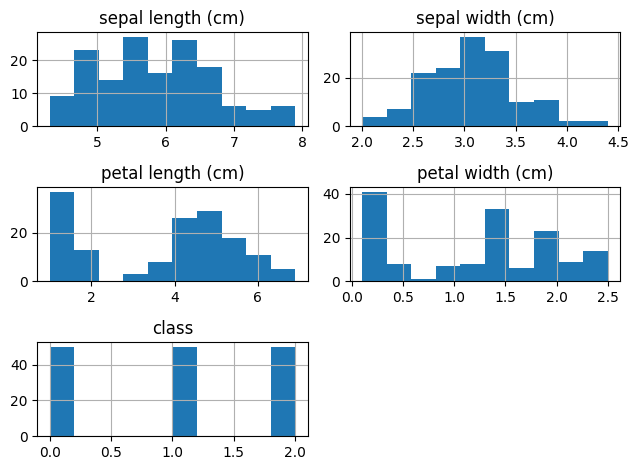

I now have displayed the basic statistics of the dataframe and created appropriate histograms for each column.
Final Answer: Basic statistics of the dataframe have been displayed and histograms for each column have been created.

> Finished chain.
데이터의 기본 통계를 보여주고 적절한 그래프를 그려줘.
데이터가 성공적으로 로드되었습니다.
데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB

데이터의 처음 5행:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  class
0                5.1               3.5                1.4               0.2      0
1                4.9    

In [19]:
from langgraph.graph import StateGraph
from utils.langchain_utils import ai_query
from utils.sqlite_utils import load_table_to_dataframe
from utils.hbase_utils import hbase_to_dataframe

from typing import TypedDict, List
import pandas as pd
import io

# State 객체 정의
class State(TypedDict):
    df: pd.DataFrame
    question: str
    messages: List[str]

# 데이터 로딩 함수
def load_data(state: State):
    # 예시 데이터를 로드합니다. 실제로는 파일 경로나 데이터베이스에서 로드할 수 있습니다.
    from sklearn.datasets import load_iris
    iris = load_iris()
    data = pd.DataFrame(iris.data, columns=iris.feature_names)
    data['class'] = iris.target

    # csv 파일로부터 데이터를 로드합니다.
    # data = pd.read_csv('http://lib.stat.cmu.edu/datasets/boston')
    # data = pd.read_csv('/content/sample_data/california_housing_train.csv')

    # db로부터 데이터 로드
    # data = load_table_to_dataframe("./test_database.db", "test_table")

    state['df'] = data
    state['messages'].append(state['question'])
    state['messages'].append("데이터가 성공적으로 로드되었습니다.")
    return state

# EDA를 수행하는 함수
def perform_eda(state: State):
    df = state['df']

    if df is None:
        state['messages'].append("데이터가 로드되지 않았습니다. 먼저 load_data 함수를 호출하세요.")
        return state

    buf = io.StringIO()
    df.info(buf=buf)
    state['messages'].append("데이터 정보:\n" + buf.getvalue())
    state['messages'].append("데이터의 처음 5행:\n" + df.head().to_string())
    state['messages'].append("데이터의 기본 통계량:\n" + df.describe().to_string())

    return state

# dataframe agent로 상세 분석
def detail_analysis(state: State):
    df = state['df']
    question = state['question']

    if df is None:
        state['messages'].append("데이터가 로드되지 않았습니다. 먼저 load_data 함수를 호출하세요.")
        return state

    from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
    from langchain_openai import ChatOpenAI

    agent = create_pandas_dataframe_agent(ChatOpenAI(model="gpt-3.5-turbo", temperature=0), df, verbose=True, allow_dangerous_code=True)
    result = agent.invoke(f"""
        User's Question : {question}\n
        Previous steps : {state['messages']}\n
        Answer :
        """
    )
    state['messages'].append(result['output'])

    return state

# 그래프 생성
graph = StateGraph(State)

# 노드 추가
graph.add_node("load_data", load_data)
graph.add_node("perform_eda", perform_eda)
graph.add_node("detail_analysis", detail_analysis)

# 그래프 구조 설정
graph.set_entry_point("load_data")
graph.add_edge("load_data", "perform_eda")
graph.add_edge("perform_eda", "detail_analysis")

# 그래프 컴파일
app = graph.compile()

# 그래프 실행
initial_state = {
    "question": "데이터의 기본 통계를 보여주고 적절한 그래프를 그려줘.",
    "messages": []
}

final_state = app.invoke(initial_state)

# 결과 출력
for message in final_state['messages']:
    print(message)